## College Football Dataset Exploration -- Packhacks 2021

**Notebook Goal: Explore the various facets of this expansive dataset, find interesting relationships between variables, and implement/propose various practical applications of this data.**

Ideas to Explore:
 - Time-Series Analysis
 - Categorical Classification
 - Variable Correlation
 - Advanced Applications

Before all of that fun stuff we need to take a step back and explore the dataset structure to extract features to use.


In [1]:
# Import the os module, for the os.walk function
import os
 
# Set the directory you want to start from
rootDir = '.'
i = 0
for dirName, subdirList, fileList in os.walk(rootDir):
    print('Found directory: %s' % dirName)
    for fname in fileList:
        print('\t%s' % fname)
    i += 1
    if i > 2:
        break

# Count the number of csv files within each folder
csv_filter = lambda x: '.csv' in x
print("\n# CSV's in year-folder:", len(list(filter(csv_filter, os.listdir(".\college_fb_data\cfbstats-com-2005-1-5-0")))))


Found directory: .
	dataset_analysis.ipynb
	tf_project.ipynb
Found directory: .\college_fb_data
Found directory: .\college_fb_data\cfbstats-com-2005-1-5-0
	conference.csv
	drive.csv
	game-statistics.csv
	game.csv
	kickoff-return.csv
	kickoff.csv
	LICENSE.txt
	pass.csv
	play.csv
	player-game-statistics.csv
	player.csv
	punt-return.csv
	punt.csv
	reception.csv
	RELEASE.txt
	rush.csv
	stadium.csv
	team-game-statistics.csv
	team.csv

# CSV's in year-folder: 17



**From this os.walk(), it's clear that the data is split into folders: each representing the years 2005-20013 inclusive.**

    len(list(filter(csv_filter, os.listdir(".\college_fb_data\cfbstats-com-2005-1-5-0"))))
    
    > 17

Within each folder there are 17 csv files, including statistics on game conferences, regions, turnout, specific plays, and players. In this notebook we are going to look for interesting trends and potential applications for this data.

## Time-Series Analysis

One of the simplest and most insightful features we can extract from this dataset is exploring the nature of how college football has evolved over the years. 

We can begin by plotting a few features over time, moving on to moderate techniques such as rolling averages, and evetually attempt advanced applications involving Recurrent Neural Networks to make predictions 

 - Average League Game Score Over Time
 - How has the distribution changed?




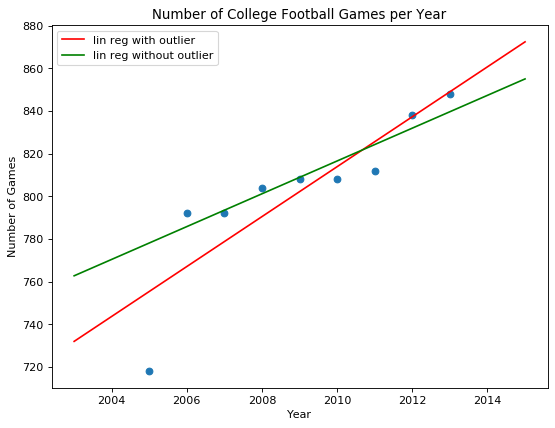

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import stats
import numpy as np

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

# load game statistics for every available year into pandas dataframes
root = "./college_fb_data/"
year_folders = os.listdir(root)[:-1]
year_game_stats = [pd.read_csv(root+i+"/game-statistics.csv") for i in year_folders]

# extract games per year and plot
years = [int(x[13:17]) for x in year_folders]
num_games_per_year = [year_game_stats[i].shape[0] for i in range(len(years))]

#print(years, num_games_per_year)
plt.scatter(years, num_games_per_year)
plt.xlabel("Year")
plt.ylabel("Number of Games")
plt.title("Number of College Football Games per Year")


# compute linear regression with/without outlier point t=2005 (Determined by IQR Test)
slope, intercept, r_value, p_value, std_err = stats.linregress(years,num_games_per_year)
mn=np.min(years)-2
mx=np.max(years)+2
x1=np.linspace(mn,mx,500)
y1=slope*x1+intercept
plt.plot(x1,y1,'-r', label='lin reg with outlier')

slope, intercept, r_value, p_value, std_err = stats.linregress(years[1:],num_games_per_year[1:])
mn=np.min(years)-2
mx=np.max(years)+2
x1=np.linspace(mn,mx,500)
y1=slope*x1+intercept
plt.plot(x1,y1,'-g', label='lin reg without outlier')

plt.legend()
plt.show()

Visually, the linear regression with the outliers removed will likely perform well for the next few years following the provided time-frame.

 However in order to achieve a more long-term model, intuitivily a logistic model will likely perform better due to the practical limits on the number of games able to be organized and enjoyed.

Let's try to visually confirm this theory.

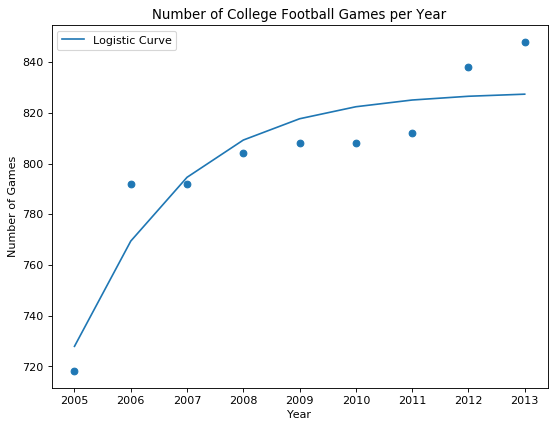

In [3]:
from scipy import optimize
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

# set reduce years size to speed up optimization
np_years = np.array(years) - 2005

# define logistic function
def logistic_function(t, a, b, c):
    return c / (1 + a * np.exp(-b*t))

# set initial conditions for logistic curve fitting
bounds = (0, [10000., 3., 100000000.])
p0 = np.array([1,1,1])
(a,b,c),cov = optimize.curve_fit(logistic_function, np_years, np.array(num_games_per_year)/1000, bounds=bounds, p0=p0)

def logistic_function(t):
    return c / (1 + a * np.exp(-b*t))

# plot original scatter
plt.scatter(years, num_games_per_year)
plt.xlabel("Year")
plt.ylabel("Number of Games")
plt.title("Number of College Football Games per Year")

# plot logistic model
plt.plot(np_years+2005, logistic_function(np_years)*1000, label='Logistic Curve')
plt.legend()
plt.show()

This logistic model provides a lower least squared loss than either linear model, confirming it's efficacy as a predictor.

## How has the game-size distribution changed over time?

Another importantelement in understanding college football games and their time-series evolution, beyong simply the number of games, is the change in the distribution of games of various sizes. 

This requires analyzing the relationship between 3-variables (time, game-size, and frequency): which we will attempt to make intuitive through an animation.


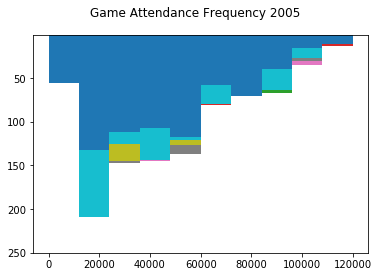

In [7]:
 from matplotlib import animation, rc
from IPython.display import HTML
 
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_ylim(250)

def animate_histogram(i):
    ax.hist(year_game_stats[i]["Attendance"], range=(0, 120000))
    fig.suptitle("Game Attendance Frequency " + str(years[i]))

anim = animation.FuncAnimation(fig, animate_histogram, frames=len(year_game_stats))
rc('animation', html='jshtml')
anim

From this annimation, we can determine that the distribution of Game attendance is relatively consistent, while being right skewed with a center (mode/median) of approx 20-40k and a mean higher due to the skew. This consistent, distribution means that the attendance data from the dataset's time frame will likely be reliable for modern extrapolation.
